In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from tempfile import TemporaryFile
import csv
import numpy as np
from skimage.transform import resize
from PIL import Image
import matplotlib.pyplot as plt
import cv2

In [0]:
X = np.load('/content/gdrive/My Drive/data_3_levels_balanced_128_128_3.npy') 
Y = np.load('/content/gdrive/My Drive/labels_3_levels_balanced.npy')

In [0]:
print(X.shape)
print(X)

(7393, 128, 128, 3)
[[[[193. 193. 185.]
   [193. 193. 185.]
   [193. 193. 185.]
   ...
   [201. 202. 188.]
   [199. 200. 186.]
   [196. 197. 183.]]

  [[194. 194. 186.]
   [194. 194. 186.]
   [194. 194. 186.]
   ...
   [201. 202. 188.]
   [199. 200. 186.]
   [196. 197. 183.]]

  [[195. 195. 187.]
   [195. 195. 187.]
   [195. 195. 187.]
   ...
   [200. 201. 187.]
   [199. 200. 186.]
   [196. 197. 183.]]

  ...

  [[200. 200. 188.]
   [199. 199. 187.]
   [198. 198. 186.]
   ...
   [126. 130. 115.]
   [122. 126. 111.]
   [182. 189. 173.]]

  [[200. 200. 188.]
   [200. 200. 188.]
   [199. 199. 187.]
   ...
   [118. 122. 107.]
   [ 91.  95.  80.]
   [155. 162. 146.]]

  [[200. 200. 188.]
   [200. 200. 188.]
   [199. 199. 187.]
   ...
   [174. 178. 163.]
   [155. 159. 144.]
   [199. 206. 190.]]]


 [[[204. 204. 192.]
   [202. 202. 190.]
   [200. 200. 188.]
   ...
   [209. 207. 195.]
   [210. 208. 196.]
   [214. 212. 200.]]

  [[204. 204. 192.]
   [203. 203. 191.]
   [201. 201. 189.]
   ...
 

In [0]:
print(Y.shape)
print(Y)

(7393, 3)
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [0]:
from sklearn.utils import shuffle
X, Y = shuffle(X, Y, random_state=0)

In [0]:
x_train = X[:6393]
y_train = Y[:6393]
print(x_train.shape)
print(y_train.shape)

(6393, 128, 128, 3)
(6393, 3)


In [0]:
x_val = X[6393:6893]
y_val = Y[6393:6893]
print(x_val.shape)
print(y_val.shape)

(500, 128, 128, 3)
(500, 3)


In [0]:
x_test = X[6893:]
y_test = Y[6893:]
print(x_test.shape)
print(y_test.shape)

(500, 128, 128, 3)
(500, 3)


(128, 128, 3)


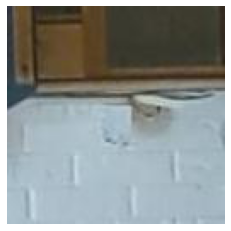

[0. 0. 1.]


In [0]:
# picking a test sample before generating adversarial examples 
Image = x_test[ 0, :]
print( Image.shape )
r,g,b = cv2.split(Image)       # get b,g,r
Image = cv2.merge([r,g,b])

plt.imshow( Image.astype('uint8') )
plt.axis( 'off' )
plt.show( )
print(y_test[2])

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [0]:
import glob
import pandas as pd
import os
import shutil 
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
%matplotlib inline

Using TensorFlow backend.


In [0]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
import keras
vgg = VGG16(include_top=False, weights='imagenet', input_shape=(128,128,3))
output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg = Model(vgg.input, output=output)
for layer in vgg.layers:
    layer.trainable = False
vgg.summary()

58892288/58889256 [==============================] - 6s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
____________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(Tensor("in..., outputs=Tensor("fl...)`
  import sys


In [0]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
from keras.regularizers import l2
model_Sigmoid = Sequential()
model_Sigmoid.add(vgg)
model_Sigmoid.add(Dense(512, activation='relu', input_dim=(128,128,3), kernel_regularizer=l2(0.001)))
model_Sigmoid.add(Dropout(0.2))
model_Sigmoid.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
model_Sigmoid.add(Dropout(0.2))
model_Sigmoid.add(Dense(3, activation='sigmoid'))
model_Sigmoid.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=0.0001),
              metrics=['accuracy'])
model_Sigmoid.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 8192)              14714688  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 1539      
Total params: 19,173,699
Trainable params: 4,459,011
Non-trainable params: 14,714,688
__________________________________

In [0]:
# RMSprop ###(lr = 0.001 -> [31.6N, 31.6N, 31.6N])###(lr = 0.0001 -> [94.99OG, 95.8GG, 95.69GG])###(lr = 0.00001 -> [91.2GG, 91.2GG, 91.2GG])###
# Adam ###(lr = 0.001 -> [31.6N, 31.6N, 31.6N])###(lr = 0.0001 -> [91.39GG, 89.6GG, 88.2GG])###(lr = 0.00001 -> [87.4GG, 87.00GG, 87.4GG])###
# SGD ###(lr = 0.001 -> [86.59GG, 86.4GG, 86.59GG])###(lr = 0.0001 -> [76.99GG, 76.99GG, 76.99GG]])###(lr = 0.00001 -> [55.59NOG, 55.59NOG, 44.2OG])###
# N = No learning, GG = Great Learning, OG = Okay Learning, U = Unlearning

#RMSprop lr = 0.0001      ### 95.99% (RMSprop, lr = 0.0001, f1 = 0.957267) ###

model_Sigmoid.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_val, y_val))

Train on 6393 samples, validate on 500 samples
Epoch 1/10
6393/6393 [==============================] - 26s 4ms/step - loss: 2.1289 - accuracy: 0.6024 - val_loss: 1.6942 - val_accuracy: 0.7260
Epoch 2/10
6393/6393 [==============================] - 12s 2ms/step - loss: 1.6026 - accuracy: 0.7912 - val_loss: 1.3926 - val_accuracy: 0.8480
Epoch 3/10
6393/6393 [==============================] - 12s 2ms/step - loss: 1.3885 - accuracy: 0.8483 - val_loss: 1.2843 - val_accuracy: 0.9260
Epoch 4/10
6393/6393 [==============================] - 12s 2ms/step - loss: 1.2804 - accuracy: 0.8747 - val_loss: 1.2202 - val_accuracy: 0.9260
Epoch 5/10
6393/6393 [==============================] - 12s 2ms/step - loss: 1.1864 - accuracy: 0.9008 - val_loss: 1.1284 - val_accuracy: 0.9200
Epoch 6/10
6393/6393 [==============================] - 12s 2ms/step - loss: 1.1177 - accuracy: 0.9115 - val_loss: 1.1203 - val_accuracy: 0.9100
Epoch 7/10
6393/6393 [==============================] - 12s 2ms/step - loss: 1.0850

In [0]:
model_Sigmoid.evaluate(x_test, y_test)

500/500 [==============================] - 3s 7ms/step


[0.953502468585968, 0.9599999785423279]

In [0]:
# predict probabilities for test set
yhat_probs_Sigmoid = model_Sigmoid.predict(x_test, verbose=0)
# predict crisp classes for test set
yhat_classes_Sigmoid = model_Sigmoid.predict_classes(x_test, verbose=0)
yhat_probs_Sigmoid = np.argmax(yhat_probs_Sigmoid, axis=1)
print(yhat_probs_Sigmoid.shape)
print(yhat_classes_Sigmoid.shape)

(500,)
(500,)


In [0]:
print(y_test.shape)
y_test_Sigmoid = np.argmax(y_test, axis=1)
print(y_test_Sigmoid.shape)

(500, 3)
(500,)


In [0]:
# accuracy: (tp + tn) / (p + n)
accuracy_Sigmoid = accuracy_score(y_test_Sigmoid, yhat_classes_Sigmoid)
print('Accuracy Sigmoid: %f' % accuracy_Sigmoid)
# precision tp / (tp + fp)
precision_Sigmoid = precision_score(y_test_Sigmoid, yhat_classes_Sigmoid, average='macro')
print('Precision Sigmoid: %f' % precision_Sigmoid)
# recall: tp / (tp + fn)
recall_Sigmoid = recall_score(y_test_Sigmoid, yhat_classes_Sigmoid, average='macro')
print('Recall Sigmoid: %f' % recall_Sigmoid)
# f1: 2 tp / (2 tp + fp + fn)
f1_Sigmoid = f1_score(y_test_Sigmoid, yhat_classes_Sigmoid, average='macro')
print('F1 score Sigmoid: %f' % f1_Sigmoid)

Accuracy Sigmoid: 0.960000
Precision Sigmoid: 0.958035
Recall Sigmoid: 0.956659
F1 score Sigmoid: 0.957267


In [0]:
model_Softmax = Sequential()
model_Softmax.add(vgg)
model_Softmax.add(Dense(512, activation='relu', input_dim=(128,128,3), kernel_regularizer=l2(0.001)))
model_Softmax.add(Dropout(0.2))
model_Softmax.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
model_Softmax.add(Dropout(0.2))
model_Softmax.add(Dense(3, activation='softmax'))
model_Softmax.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=0.001),
              metrics=['accuracy'])
model_Softmax.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 8192)              14714688  
_________________________________________________________________
dense_4 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 1539      
Total params: 19,173,699
Trainable params: 4,459,011
Non-trainable params: 14,714,688
__________________________________

In [0]:
# RMSprop ###(lr = 0.001 -> [97.2OG, 96.39OG, 95.8OG])###(lr = 0.0001 -> [97.39GG, 97.79GG, 97.79GG])###(lr = 0.00001 -> [97.39GG, 97.39GG, 97.39G])###
# Adam ###(lr = 0.001 -> [97.6OG, 97.2OG, 97.6OG])###(lr = 0.0001 -> [97.6OG, 97.2OG, 97.6OG])###(lr = 0.00001 -> [97.00GG, 97.00GG, 97.00GG])###
# SGD ###(lr = 0.001 -> [98.19OG, 97.79OG, O97.79G])###(lr = 0.0001 -> [96.79GG, 96.79GG, 96.79GG])###(lr = 0.00001 -> [81.99GG, 81.99GG, 77.6GG])###
# N = No learning, GG = Great Learning, OG = Okay Learning, U = Unlearning

#SGD lr = 0.001         ### 98.0% (SGD, lr = 0.001, f1 = 0.979414) ###

model_Softmax.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_val, y_val))

Train on 6393 samples, validate on 500 samples
Epoch 1/10
6393/6393 [==============================] - 12s 2ms/step - loss: 3.0728 - accuracy: 0.7752 - val_loss: 1.6367 - val_accuracy: 0.9580
Epoch 2/10
6393/6393 [==============================] - 12s 2ms/step - loss: 1.8826 - accuracy: 0.8932 - val_loss: 1.5763 - val_accuracy: 0.9620
Epoch 3/10
6393/6393 [==============================] - 12s 2ms/step - loss: 1.7279 - accuracy: 0.9287 - val_loss: 1.5530 - val_accuracy: 0.9740
Epoch 4/10
6393/6393 [==============================] - 12s 2ms/step - loss: 1.6664 - accuracy: 0.9438 - val_loss: 1.5328 - val_accuracy: 0.9780
Epoch 5/10
6393/6393 [==============================] - 12s 2ms/step - loss: 1.6218 - accuracy: 0.9542 - val_loss: 1.5158 - val_accuracy: 0.9900
Epoch 6/10
6393/6393 [==============================] - 12s 2ms/step - loss: 1.6084 - accuracy: 0.9579 - val_loss: 1.5253 - val_accuracy: 0.9860
Epoch 7/10
6393/6393 [==============================] - 12s 2ms/step - loss: 1.5931

In [0]:
model_Softmax.evaluate(x_test, y_test)

500/500 [==============================] - 1s 2ms/step


[1.5780257997512817, 0.9800000190734863]

In [0]:
# predict probabilities for test set
yhat_probs_Softmax = model_Softmax.predict(x_test, verbose=0)
# predict crisp classes for test set
yhat_classes_Softmax = model_Softmax.predict_classes(x_test, verbose=0)
yhat_probs_Softmax = np.argmax(yhat_probs_Softmax, axis=1)
print(yhat_probs_Softmax.shape)
print(yhat_classes_Softmax.shape)

(500,)
(500,)


In [0]:
print(y_test.shape)
y_test_Softmax = np.argmax(y_test, axis=1)
print(y_test_Softmax.shape)

(500, 3)
(500,)


In [0]:
# accuracy: (tp + tn) / (p + n)
accuracy_Softmax = accuracy_score(y_test_Softmax, yhat_classes_Softmax)
print('Accuracy Softmax: %f' % accuracy_Softmax)
# precision tp / (tp + fp)
precision_Softmax = precision_score(y_test_Softmax, yhat_classes_Softmax, average='macro')
print('Precision Softmax: %f' % precision_Softmax)
# recall: tp / (tp + fn)
recall_Softmax = recall_score(y_test_Softmax, yhat_classes_Softmax, average='macro')
print('Recall Softmax: %f' % recall_Softmax)
# f1: 2 tp / (2 tp + fp + fn)
f1_Softmax = f1_score(y_test_Softmax, yhat_classes_Softmax, average='macro')
print('F1 score Softmax: %f' % f1_Softmax)

Accuracy Softmax: 0.980000
Precision Softmax: 0.981776
Recall Softmax: 0.977756
F1 score Softmax: 0.979414
